In [2]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 


In [3]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

pd.options.display.max_rows = 200

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 192 results
transitions_data returned 11 results
total_population_data returned 168 results
initialization time:  15.494980812072754
simulation_time:  10.555407285690308
initialization time:  15.752671957015991
simulation_time:  10.489333152770996
initialization time:  15.616923093795776
simulation_time:  10.470804929733276


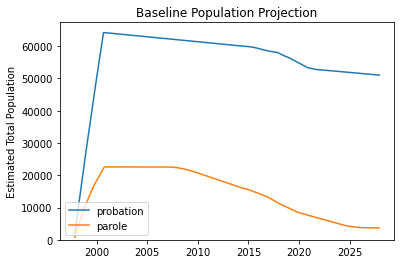

In [7]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/TN/TN_prison_revocations_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
test_sim.simulate_baseline(['probation', 'parole'])

,x
parole,1.173082
prison_parole_revocations,0.972894
prison_probation_revocations,0.937571
probation,1.093906


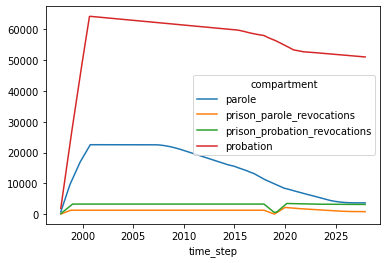

In [11]:
# need to have run baseline for this to work: checking the scale factors are decently close to 1 and population projections look reasonable
t = test_sim.pop_simulations['baseline'].population_projections.groupby(['time_step', 'compartment']).total_population.sum().unstack().drop('release',axis=1)
t.index = test_sim._convert_to_absolute_year(t.index)
t.plot()
test_sim.pop_simulations['baseline'].gen_scale_factors_df()


In [12]:
#reminding myself what the sub-groups are, in this case there's just one monolithic group
test_sim.pop_simulations['baseline'].sub_group_ids_dict

{'x': {'crime': 'x'}}

In [14]:
test_sim.pop_simulations['baseline'].sub_simulations['x'].simulation_compartments['probation'].outflows_data

time_step,36,37,38,39,40,41,42,43,44,45,...,50,51,52,53,54,55,56,57,58,59
outflow_to,,,,,,,,,,,,,,,,,,,,,
prison_probation_revocations,236.0,236.0,236.0,236.0,236.0,236.0,236.0,236.0,236.0,236.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,992.0,992.0,992.0,992.0,992.0,992.0,992.0,992.0,992.0,992.0


initialization time:  17.072229146957397
simulation_time:  11.218891620635986
initialization time:  17.423319816589355
simulation_time:  11.43030333518982


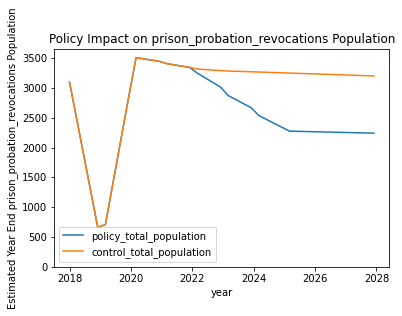

In [22]:
# Policy Option Methods
revocation_outflows = {
    'parole': 'prison_parole_revocations',
    'probation': 'prison_probation_revocations',
}
REVOCATION_REDUCTION = 0.3

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(CompartmentTransitions.reallocate_outflow, 
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': ['release']
                   }),
                   reallocation_type='*',
                   retroactive=retroactive)


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'crime': 'x'},
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison_probation_revocations')

In [23]:
simulation_tag = 'TN_PO_incentives_30%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)